# Анализ моделей прогнозирования погодных условий.
Выполнил Старинчиков В.Д.

## Подготовка данных

Получение датафрейма архивных погодных условий с Питерской вышки.

Обговорим сразу, что для сложных моделей будем считать температуру воздуха целевой метрикой, так как эта метрика интересна нам ввиду высокого влияния на комфорт и ввиду высокой вычислительной нагрузки при обучении моделей. Однако, если сложность алгоритмов будет позволять, то постараемся построить прогноз и для остальных метрик, указанных в ТЗ.

Также сразу определимся с метрикой для сравнения моделей. Из задачи следует, что наша модель должна корректно обрабатывать выбросы. Из этой предпосылки предлагаю метрику **RMSE** - Root Mean Square Error. Она не робастна (чувствительна к выбросам) и легко интерпретируема. Это значение отвечает на вопрос "На сколько в среднем прогноз отклоняется от реального значения, учитывая выбросы?"

Установка зависимостей

In [114]:
#!pip install meteostat
# !pip install termcolor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import meteostat
from datetime import datetime
from matplotlib import pyplot
from numpy import arange
from numpy.random import seed
from pandas import read_parquet, Series
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from termcolor import colored
from warnings import simplefilter

In [115]:
df = meteostat.Hourly(loc='26063', end=datetime.now())
df = df.fetch()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 376580 entries, 1931-04-01 18:00:00 to 2025-01-18 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    375008 non-null  float64
 1   dwpt    358712 non-null  float64
 2   rhum    358712 non-null  float64
 3   prcp    22772 non-null   float64
 4   snow    788 non-null     float64
 5   wdir    355997 non-null  float64
 6   wspd    375726 non-null  float64
 7   wpgt    56989 non-null   float64
 8   pres    273317 non-null  float64
 9   tsun    0 non-null       float64
 10  coco    62127 non-null   float64
dtypes: float64(11)
memory usage: 34.5 MB


Проверим есть ли в наборе данных пустые значения

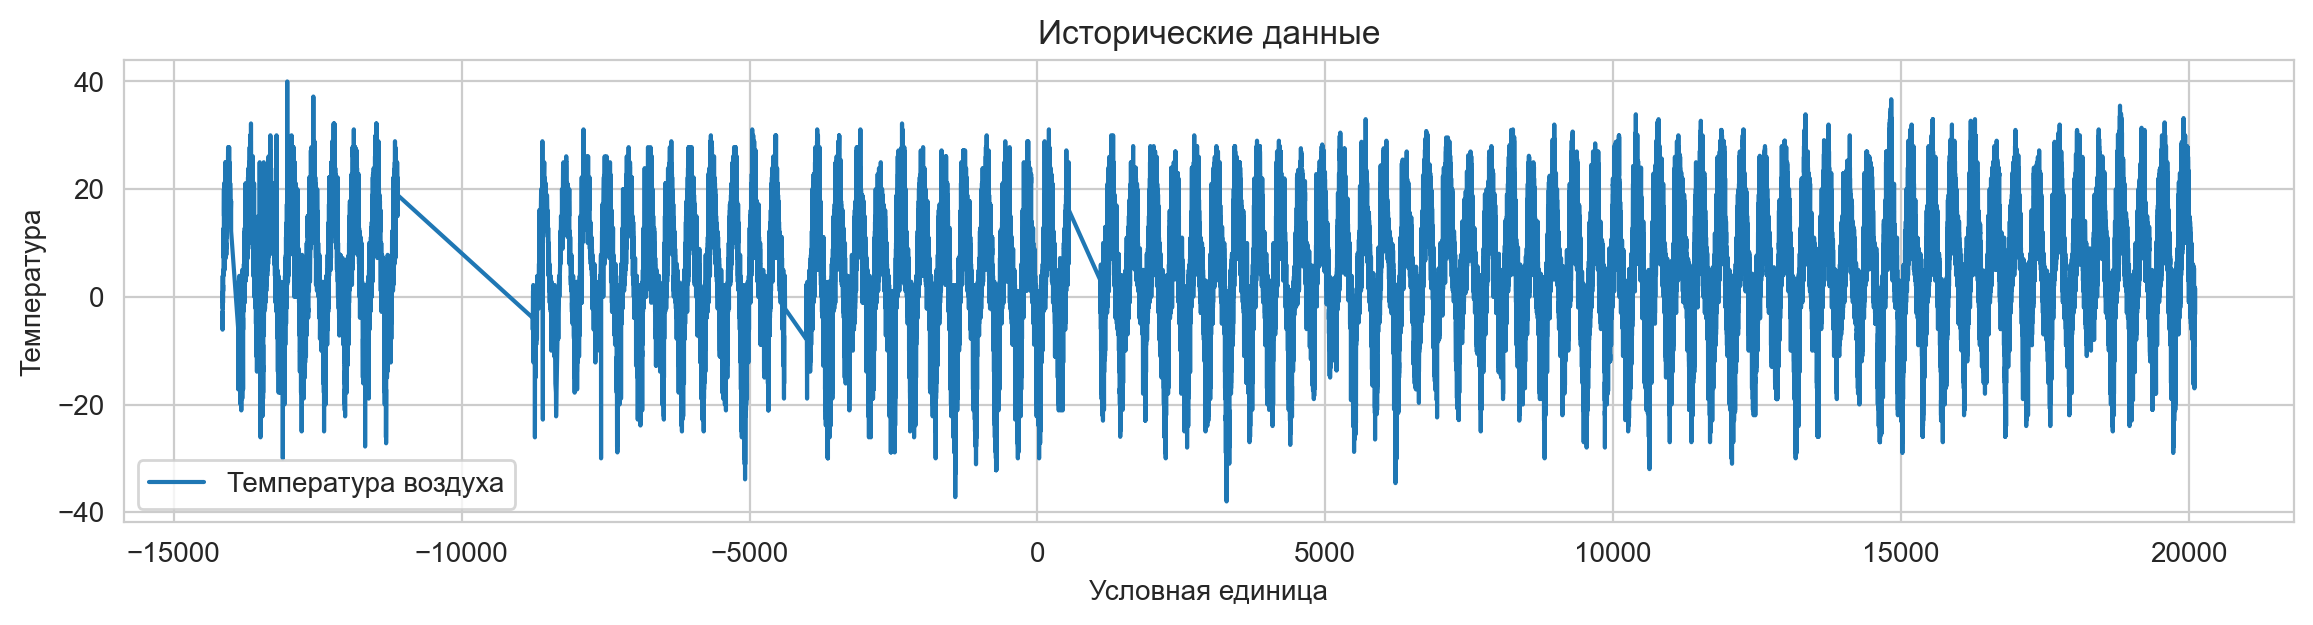

In [116]:
import matplotlib.dates as mdates

plt.figure(figsize=(14, 3), dpi=200)

sns.lineplot(x=mdates.date2num(df.index), y=df.temp, label='Температура воздуха')
plt.title('Исторические данные')
plt.ylabel('Температура')
plt.xlabel('Условная единица')
plt.show()

Пустые данные и вправду есть. Обработка нецелесообразна, так как временной ряд является единой структурой данных. При заполнении большого промежутка мы внесем изменения в структуру и тем самым испортим прогноз. Также нельзя и просто оставить пропуски, так как это изменяет сезонный паттерн, что плохо скажется на моделях. Помимо этого интерполяция данных также внесет несуществующую структуру в данные.

Из всего выше сказанного предлагаю найти максимальный почасовой отрезок в данных и использовать в обучении только его.

date_diff
0 days 01:00:00    62441
Name: count, dtype: int64


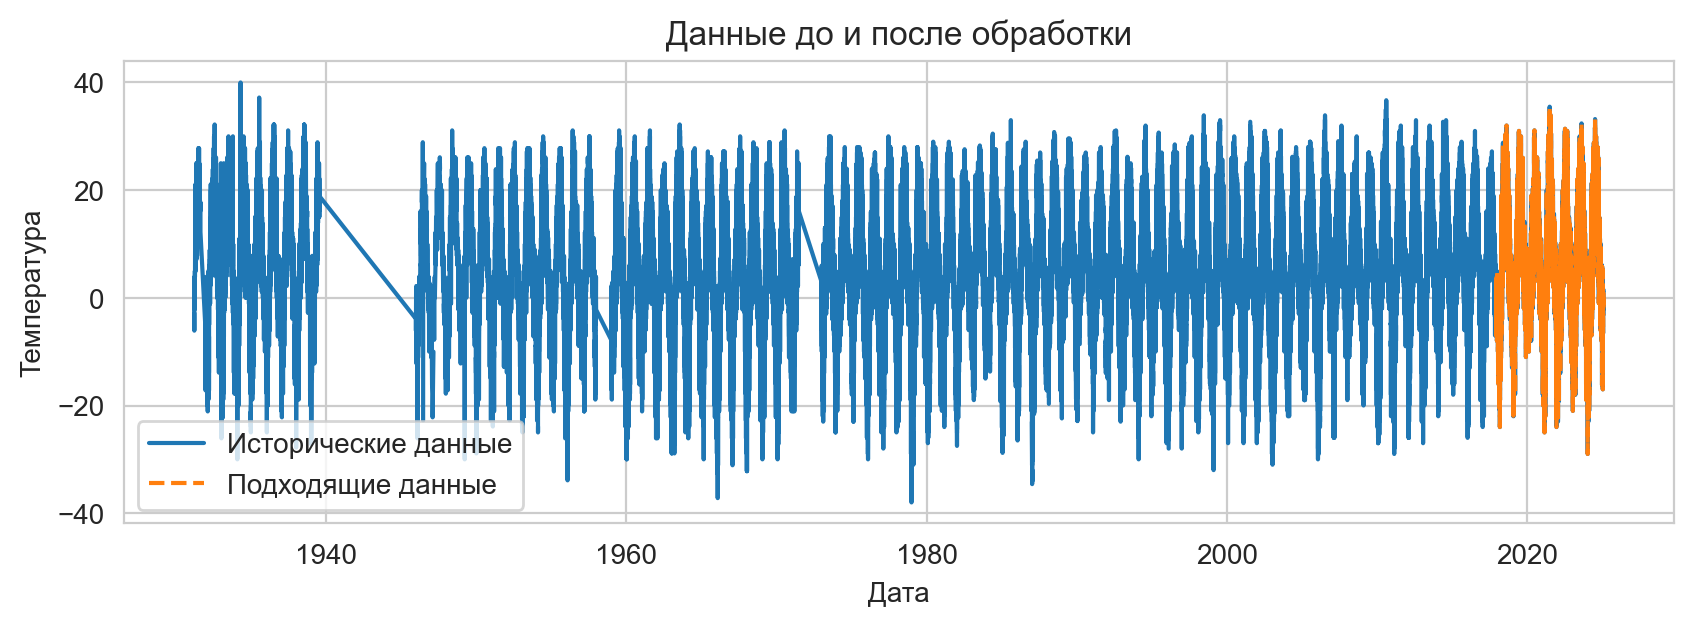

In [117]:
# Шаг 1: Найдем разницу между соседними датами
df['date_diff'] = df.index.to_series().diff().fillna(pd.Timedelta(days=0))

# Шаг 2: Найдем индексы, где разница больше одного дня
gap_indices = df[df['date_diff'] > pd.Timedelta(hours=1)].index

# Шаг 3: Если такие индексы есть, найдем последний
if not gap_indices.empty:
    last_gap_index = gap_indices[-1]  # Последний индекс с пропуском
    df_trimmed = df.loc[last_gap_index:]  # Обрезаем DataFrame до этого индекса
else:
    df_trimmed = df  # Если пропусков нет, оставляем DataFrame без изменений

print(df_trimmed[1:].date_diff.value_counts())

# Удаляем вспомогательный столбец
df_trimmed = df_trimmed.drop(columns=['date_diff'])

# Построить график
plt.figure(figsize=(10, 3), dpi=200)

# Построить оригинальные данные
plt.plot(df.index, df['temp'], linestyle='-', label='Исторические данные')

# Построить обрезанные данные
plt.plot(df_trimmed.index, df_trimmed['temp'], linestyle='--', label='Подходящие данные')

plt.title('Данные до и после обработки')
plt.xlabel('Дата')
plt.ylabel('Температура')
plt.legend()
plt.grid(True)
plt.show()

In [118]:
df = df_trimmed
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62442 entries, 2017-12-05 06:00:00 to 2025-01-18 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    62442 non-null  float64
 1   dwpt    62442 non-null  float64
 2   rhum    62442 non-null  float64
 3   prcp    22772 non-null  float64
 4   snow    788 non-null    float64
 5   wdir    62007 non-null  float64
 6   wspd    62436 non-null  float64
 7   wpgt    56989 non-null  float64
 8   pres    62231 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    59019 non-null  float64
dtypes: float64(11)
memory usage: 5.7 MB


Итого имеем датафрейм без пропусков в столбце температуры. Также посмотрим на остальные столбцы.

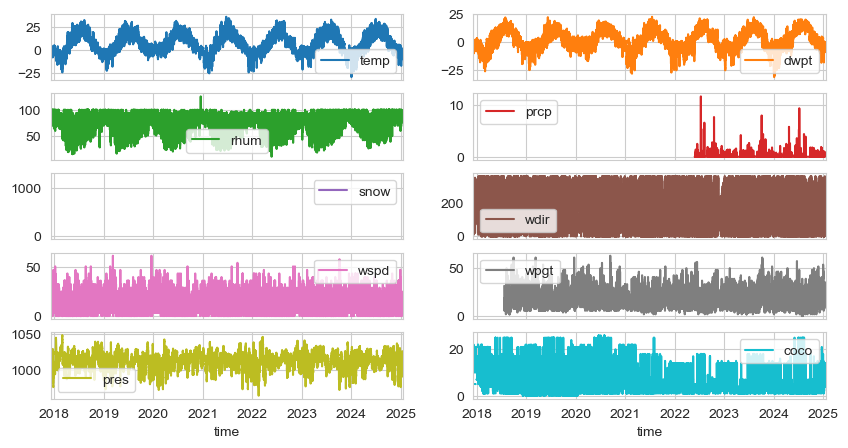

In [119]:
df.drop(columns=['tsun']).plot(subplots=True, layout=(5,2), figsize=(10, 5))
sns.set_style("whitegrid")
plt.show()

Судя по характеристике датафрейма, график снега отображается некорректно, убедимся в этом.

In [120]:
df[~(df.snow.isnull())]

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-27 06:00:00,1.7,0.5,92.0,NaN,10.0,180.0,7.2,NaN,1020.9,NaN,4.0
2018-01-28 06:00:00,0.5,-1.4,87.0,NaN,30.0,240.0,7.2,NaN,1016.6,NaN,4.0
2018-01-29 06:00:00,-0.6,-2.0,90.0,NaN,30.0,110.0,3.6,NaN,1005.6,NaN,14.0
2018-01-30 06:00:00,-7.0,-9.1,85.0,NaN,70.0,50.0,7.2,NaN,999.8,NaN,4.0
2018-01-31 06:00:00,-10.1,-12.3,84.0,NaN,70.0,330.0,7.2,NaN,1009.4,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-04 06:00:00,-4.6,-6.0,90.0,0.2,140.0,0.0,0.0,5.5,996.2,NaN,14.0
2025-01-05 06:00:00,-3.2,-4.0,94.0,0.0,160.0,280.0,7.0,20.4,997.7,NaN,14.0
2025-01-06 06:00:00,-6.6,-8.3,88.0,0.0,150.0,0.0,0.0,11.1,1008.5,NaN,4.0


Некоторые столбцы начали вестись позже почасового отслеживания показателей, а именно скорость ветра и количество осадков. Для корректной работы предлагаю оставить значения до первой записи пустыми, а после записывать 0 вместо показателя, основываясь на логике.

Также есть редкие пропуски в столбце с давлением, направлением ветра и тд, такие единичные пропуски проинтерполируем.

In [121]:
# Функция для обработки каждой колонки
def replace_nan_after_first_non_nan(column):
    if column.name == 'pres' or column.name == 'wdir' or column.name == 'coco':
        return column
    first_non_nan_index = column.first_valid_index()
    if first_non_nan_index is not None:
        # Получаем позицию первого не-NaN значения
        pos = column.index.get_loc(first_non_nan_index)
        # Заменяем только NaN значения после первого не-NaN на 0
        column.iloc[pos + 1:] = column.iloc[pos + 1:].apply(lambda x: 0 if pd.isna(x) else x)
    return column

# Применение функции к каждой колонке
df = df.apply(replace_nan_after_first_non_nan)

df.pres = df.pres.interpolate(method='time')
df.wdir = df.wdir.interpolate(method='time')
df.coco = df.wdir.interpolate(method='time')

Посмотрим на итоговый датафрейм.
Отмечу, что данные в столбцах tsun и wpgt нас не интересуют ввиду их отсутствия в ТЗ.

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62442 entries, 2017-12-05 06:00:00 to 2025-01-18 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    62442 non-null  float64
 1   dwpt    62442 non-null  float64
 2   rhum    62442 non-null  float64
 3   prcp    23229 non-null  float64
 4   snow    61170 non-null  float64
 5   wdir    62442 non-null  float64
 6   wspd    62442 non-null  float64
 7   wpgt    56989 non-null  float64
 8   pres    62442 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    62442 non-null  float64
dtypes: float64(11)
memory usage: 7.7 MB


In [123]:
df

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2017-12-05 06:00:00,-1.4,-3.8,84.0,NaN,NaN,280.0,7.2,NaN,1005.5,NaN,280.0
2017-12-05 07:00:00,-1.0,-4.0,80.0,NaN,NaN,290.0,14.4,NaN,1005.0,NaN,290.0
2017-12-05 08:00:00,-1.0,-4.0,80.0,NaN,NaN,270.0,10.8,NaN,1005.0,NaN,270.0
2017-12-05 09:00:00,-0.6,-3.6,80.0,NaN,NaN,250.0,3.6,NaN,1005.6,NaN,250.0
2017-12-05 10:00:00,0.0,-3.0,80.0,NaN,NaN,200.0,7.2,NaN,1005.3,NaN,200.0
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-18 19:00:00,-2.7,-5.3,82.0,0.0,0.0,263.0,9.3,27.8,1009.0,NaN,263.0
2025-01-18 20:00:00,-2.7,-5.3,82.0,0.0,0.0,263.0,9.3,27.8,1009.1,NaN,263.0
2025-01-18 21:00:00,-2.8,-5.3,83.0,0.0,0.0,262.0,9.3,25.9,1009.2,NaN,262.0


## Наивные модели

На самом деле в нашей задаче наивные модели - пожалуй лучший компромисс между мощностью и скоростью, так как такие модели очень просты по нотации *Big O* (сложность константная - скорость максимальна) и они хорошо описывают значения, сильно зависящие от сезонности. [Источник (тайминг: 5.55)](https://www.youtube.com/watch?v=o9573dTagaE&list=PLCf-cQCe1FRyNQwG5UT3NglKCp8Snrj5r&index=5)

Однако, сравнение моделей необходимо.

### Осреднение

Разбиение данных на обучающую и тестовую выборки. Также удалим пустой столбец с количеством солнечных дней и не нужный столбец wpgt.

In [124]:
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

df.drop(columns=['tsun', 'wpgt'], inplace=True)

In [125]:
split_date = '2025-01-01'

train_df = df[df.index < split_date]
test_df = df[('2025-01-11' >= df.index) & (df.index >= split_date)]

Вычисление среднего значения для каждой даты

In [126]:
train_group = train_df.groupby(['month', 'day', 'hour']).mean().reset_index()
test_features = test_df[['month', 'day', 'hour']].reset_index()
train_group

,month,day,hour,temp,dwpt,rhum,prcp,snow,wdir,wspd,pres,coco
0,1,1,0,-1.928571,-4.471429,83.142857,0.10,0.0,221.428571,9.771429,1007.600000,221.428571
1,1,1,1,-2.428571,-4.428571,86.142857,0.25,0.0,222.857143,13.885714,1006.847619,222.857143
2,1,1,2,-2.285714,-4.714286,83.571429,0.00,0.0,223.428571,13.371429,1006.309524,223.428571
3,1,1,3,-2.171429,-4.528571,84.285714,0.00,0.0,230.000000,11.314286,1006.542857,230.000000
4,1,1,4,-2.571429,-4.742857,85.142857,0.00,0.0,232.428571,14.914286,1005.600000,232.428571
...,...,...,...,...,...,...,...,...,...,...,...,...
8779,12,31,19,-1.750000,-4.262500,83.375000,0.00,0.0,240.000000,16.600000,1007.350000,240.000000
8780,12,31,20,-2.125000,-4.512500,84.000000,0.00,0.0,233.500000,15.725000,1007.300000,233.500000
8781,12,31,21,-1.700000,-4.500000,81.625000,0.00,0.0,252.500000,9.025000,1008.012500,252.500000
8782,12,31,22,-2.500000,-5.000000,83.125000,0.00,0.0,226.250000,14.400000,1007.087500,226.250000


Строим прогноз

In [127]:
predictions = test_features.merge(train_group, on=['month', 'day', 'hour'], how='left', suffixes=('', '_pred'))
predictions = predictions.drop(columns=['month', 'day', 'hour'])
predictions = predictions.dropna()
predictions

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,pres,coco
0,2025-01-01 00:00:00,-1.928571,-4.471429,83.142857,0.10,0.0,221.428571,9.771429,1007.600000,221.428571
1,2025-01-01 01:00:00,-2.428571,-4.428571,86.142857,0.25,0.0,222.857143,13.885714,1006.847619,222.857143
2,2025-01-01 02:00:00,-2.285714,-4.714286,83.571429,0.00,0.0,223.428571,13.371429,1006.309524,223.428571
3,2025-01-01 03:00:00,-2.171429,-4.528571,84.285714,0.00,0.0,230.000000,11.314286,1006.542857,230.000000
4,2025-01-01 04:00:00,-2.571429,-4.742857,85.142857,0.00,0.0,232.428571,14.914286,1005.600000,232.428571
...,...,...,...,...,...,...,...,...,...,...
236,2025-01-10 20:00:00,-5.285714,-6.985714,87.857143,0.00,0.0,244.285714,17.485714,1017.142857,244.285714
237,2025-01-10 21:00:00,-4.042857,-5.585714,89.000000,0.00,0.0,202.857143,8.228571,1017.814286,202.857143
238,2025-01-10 22:00:00,-5.285714,-6.857143,88.714286,0.00,0.0,237.142857,18.514286,1017.142857,237.142857
239,2025-01-10 23:00:00,-5.428571,-7.157143,87.714286,0.05,0.0,238.571429,17.485714,1017.142857,238.571429


Вычисление средней ошибки RMSE

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


for column in df.columns[:-3]:  # Исключаем 'month', 'day', 'hour'
    if column in predictions.columns and column in train_group.columns:
        pred_vals = predictions[column]
        true_vals = test_df[column]
        mse = mean_squared_error(true_vals, pred_vals)
        print(f'Variable: {column}, RMSE: {mse**0.5}')

Variable: temp, RMSE: 3.763221589900584
Variable: dwpt, RMSE: 4.306290951188457
Variable: rhum, RMSE: 7.726208705238118
Variable: prcp, RMSE: 0.27595552591342987
Variable: snow, RMSE: 20.35558721441626
Variable: wdir, RMSE: 96.53636294588101
Variable: wspd, RMSE: 5.8607525707949195
Variable: pres, RMSE: 15.407870398612955
Variable: coco, RMSE: 96.53636294588101


Итого характеристика прогноза осреднением исторических данных.

Плюсы:
- Скорость. Сложность построения прогноза на заданную дату по нотации Big O - константная. То есть алгоритм имеет самую быструю скорость из возможных.
- Простота. Модель легко переносится на целевой язык C++.
- Универсальность. Модель едина на все возможные вышки и метрики, не требуя обучения.

Минусы:
- Ошибка. RMSE = 3.7 означает, что учитывая выбросы, модель ошибается в среднем на 3.7 градусов. Требуется рассмотреть остальные модели для понимания качества такого прогноза.

### Наивная сезонная модель

Для построения сезонной модели требуется нахождение сезонности. Сделаем это при помощи графика функции автокорреляции. Из логики следует, что сезонность составляет `365*24=8760` значений. Сделаем тики с заданным интервалом и посмотрим на то, как значения будут зависить друг от друга на этих точках.

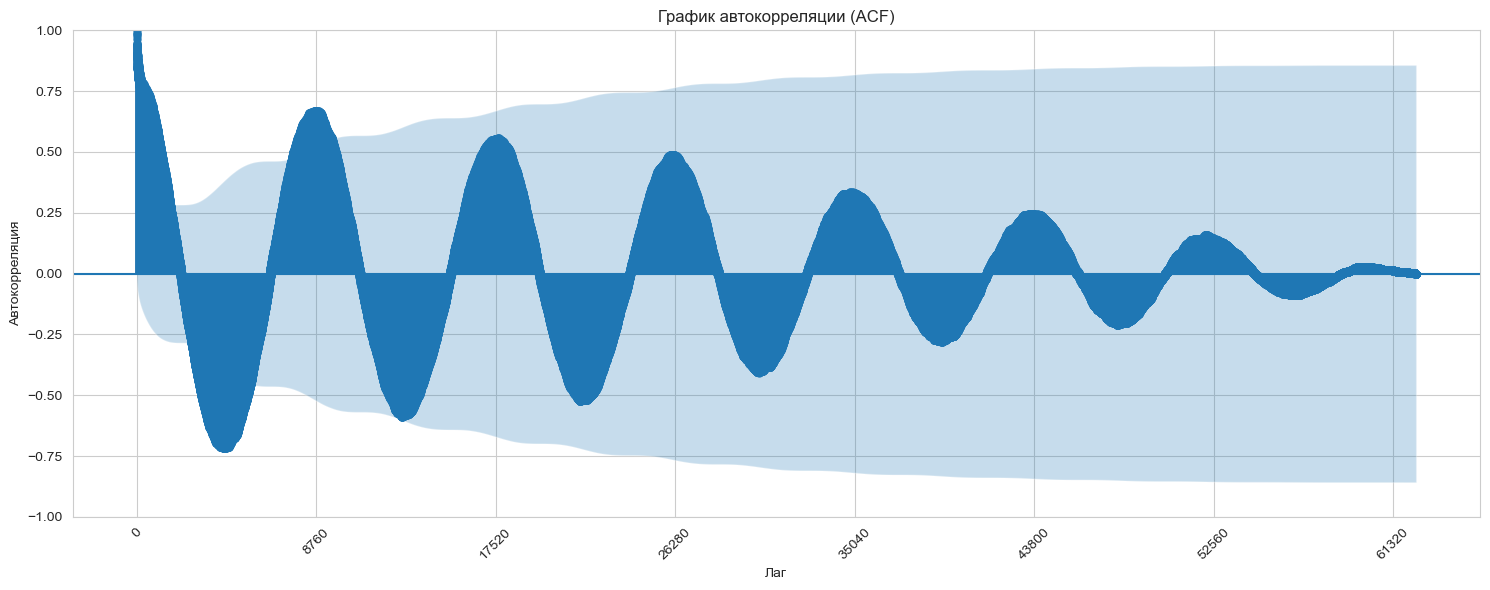

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(15, 6)) 

plot_acf(df.temp, lags=np.arange(len(df.temp)), alpha=0.05, ax=ax)

xticks_positions = np.arange(0, len(df.temp), 8760) 
xticks_labels = [f"{int(i)}" for i in xticks_positions] 
plt.xticks(xticks_positions, xticks_labels, rotation=45) 

plt.title('График автокорреляции (ACF)')
plt.xlabel('Лаг')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.tight_layout()
plt.show()

И вправду каждый 8760 тик автокорреляция достигает своего пика, значит сезонность определена верно.

Построим модель.

In [129]:
split_date = '2025-01-01'

train_df = df[df.index < split_date]
test_df = df[('2025-01-11' >= df.index) & (df.index >= split_date)]
start_idx = len(train_df) - 8760

In [133]:
seasonal_lag = 8760
predictions_df = train_df.iloc[-seasonal_lag:-seasonal_lag+len(test_df)].copy()
predictions_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [134]:
excluded_columns = ['month', 'day', 'hour']
columns_to_evaluate = [col for col in df.columns if col not in excluded_columns]

for column in columns_to_evaluate:
    if column in predictions_df.columns:
        pred_vals = predictions_df[column]
        true_vals = test_df[column]
        mse = mean_squared_error(true_vals, pred_vals)
        rmse = mse ** 0.5
        print(f'Variable: {column}, RMSE: {rmse}')

Variable: temp, RMSE: 13.873698211893208
Variable: dwpt, RMSE: 14.404347545646337
Variable: rhum, RMSE: 8.653064120425732
Variable: prcp, RMSE: 0.280929104625573
Variable: snow, RMSE: 41.0444552029207
Variable: wdir, RMSE: 153.0576058397432
Variable: wspd, RMSE: 11.044959046187097
Variable: pres, RMSE: 22.82800565804318
Variable: coco, RMSE: 153.0576058397432


Ошибка зашкаливает. Модель не прошла тестирование.

## Модель ETS

Перейдем к более сложным математическим моделям. Начнем с простой модели Error+Trend+Seasonality(ETS). 

Данная модель включает в себя случайную ошибку, ее влияние на прогноз (краткосрочный уровень), тренд (долгосрочный уровень) и сезонность. Влияние каждого из этих параметров настраивается отдельно.

Прежде нужно конкретизировать тип модели, разложим ряд.

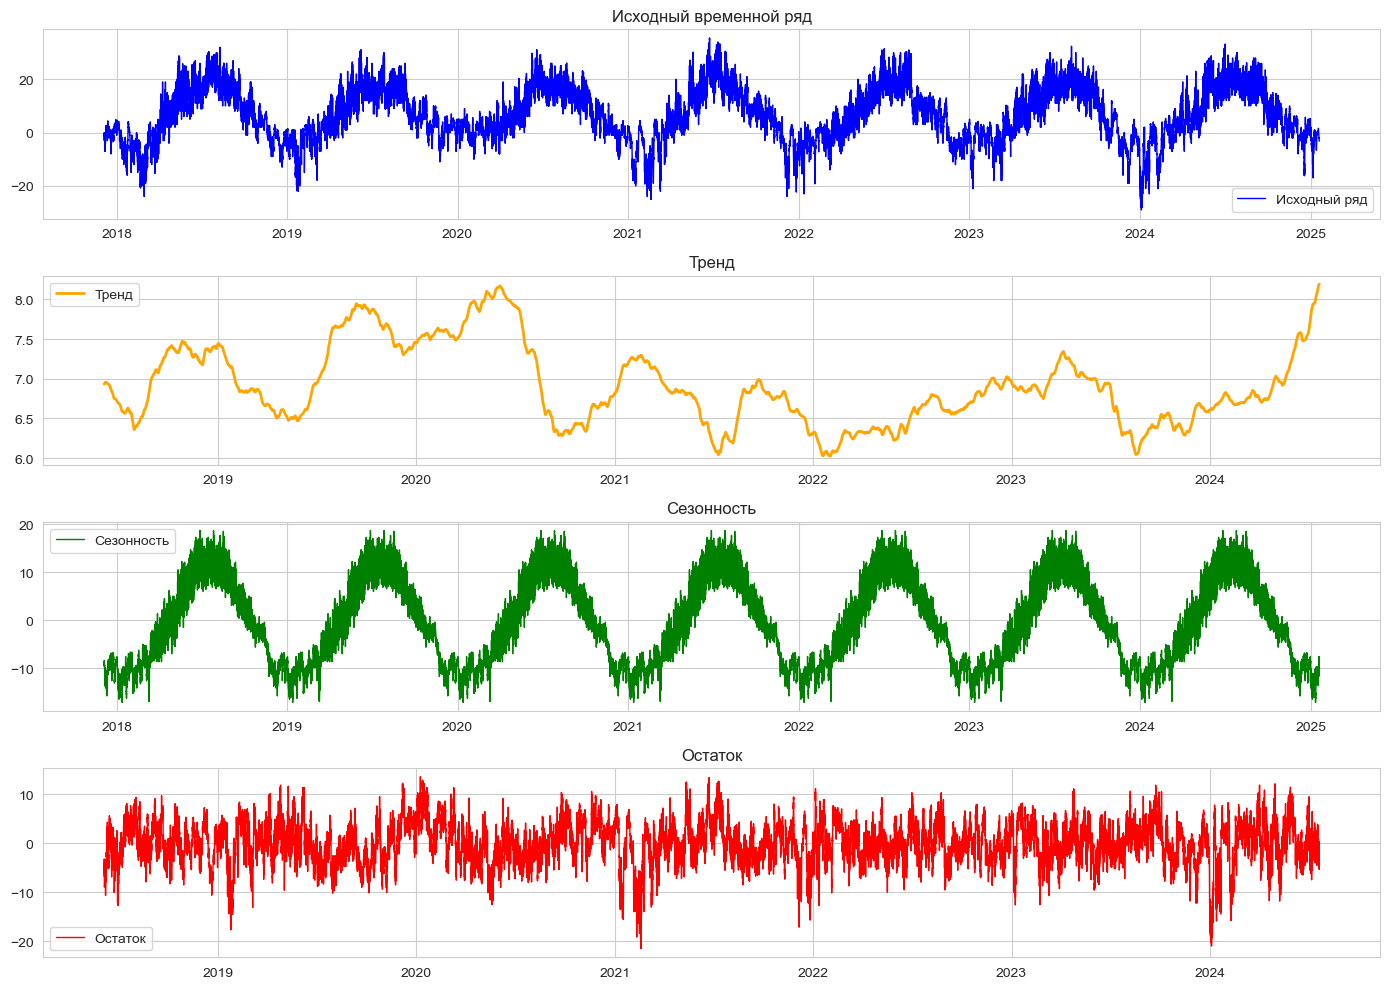

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.temp, model='additive', period=24*365)

# Создание графика с настройками
plt.figure(figsize=(14, 10))  # Размер графика

# Исходный ряд
plt.subplot(4, 1, 1)
plt.plot(df.temp, label='Исходный ряд', color='blue', linewidth=1)
plt.title('Исходный временной ряд')
plt.legend()

# Тренд
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Тренд', color='orange', linewidth=2)
plt.title('Тренд')
plt.legend()

# Сезонность
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Сезонность', color='green', linewidth=1)
plt.title('Сезонность')
plt.legend()

# Остаток
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Остаток', color='red', linewidth=1)
plt.title('Остаток')
plt.legend()

# Улучшение компоновки
plt.tight_layout()
plt.show()

В данных заметна явная неизменная сезонность. Также ошибки выглядят гомоскедастичными (дисперсия постояна), а тренд выглядит непостоянным и прямым.

Проверим предположение о гомоскедастичности остатков. Для этого проведем статистический тест Дики-Фуллера. Он проверит ряд остатков на стационарность. Если p-value окажется менее 0.05, то ряд стационарен, значит дисперсия ряда постоянна.

In [16]:
from statsmodels.tsa.stattools import adfuller

residuals = result.resid[~(result.resid.isnull())]
adf_res = adfuller(residuals)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])

ADF Statistic: -14.884867878676495
p-value: 1.5891146493855228e-27


Отлично, ряд стационарен, значит случайная ошибка аддитивна. Теперь проверим данные на наличие тренда. Для этого используем тест Манна-Кендалла. Если   p-value будет менее 0.05, то тренд присутствует.

In [17]:
# !pip install pymannkendall

In [18]:
import pymannkendall as mk

mk_result = mk.original_test(df.temp)
print(mk_result)

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=9.965670993564498, Tau=0.02658379136117621, s=51824316.0, var_s=27042949070798.668, slope=1.9309989701338814e-05, intercept=5.397132466529351)


Тренд обнаружен, но его мощность составляет всего 0.03 (0 - отсутствие тренда, 1 - сильный тренд). Я не буду включать его в итоговую модель, так как такая мощность тренда проявится на данных только через десяток лет, а наличие тренда также заставит модель считать, что в данных имеется долговременный эффект случайных ошибок, который может привести к внезапным результатам. 

Итого мы используем модель ETS(ANA).

![ETS(ANA)](DATA/ANA.png)

где 
- y - значение на t-ый день
- s - сезонность
- l - текущий уровень значения
- ε - случайная ошибка с математическим ожиданием равным нулю
- α, ɣ - коэффиценты влияния параметра на прогноз

Обучим модель.

In [19]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from time import time

start = time()
# ETS модель с годовой сезонностью
model = ExponentialSmoothing(df.temp[:-200], seasonal='add', seasonal_periods=8760)
fit = model.fit()

print(f'learning time: {time() - start}')
print(f"AIC: {fit.aic}")

learning time: 23956.001008749008
AIC: 15458.131504036006


Составим прогноз, вычислим RMSE и визуализируем прогноз.

In [20]:
forecast = fit.forecast(steps=200)

# RMSE на тестовых данных
rmse_test = np.sqrt(mean_squared_error(df.temp[-200:], forecast))
print(f"RMSE на тестовых данных: {rmse_test}")

RMSE на тестовых данных: 3.720015646781871


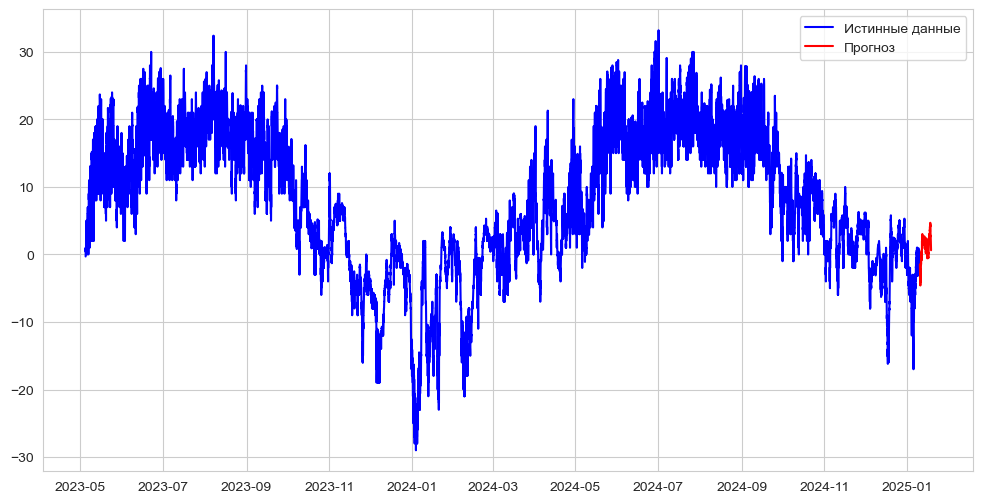

In [21]:
plt.figure(figsize=(12, 6))

# Истинные данные
plt.plot(df.index[-15000:-200], df.temp[-15000:-200], label="Истинные данные", color="blue")

# Прогноз
forecast_index = df.index[-200:]  # Используем индексы из исходного DataFrame
plt.plot(forecast_index, forecast, label="Прогноз", color="red")

plt.legend()
plt.show()

Также посмотрим на то, как себя ведет прогноз на большом расстоянии.

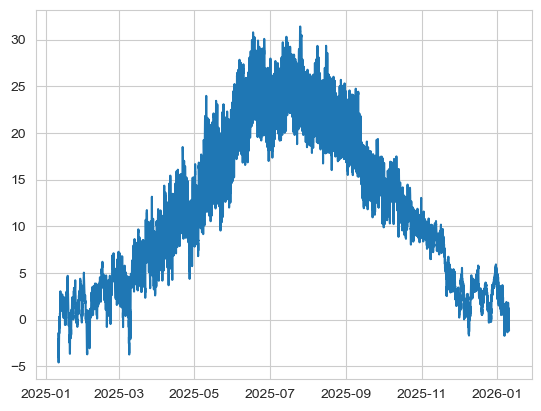

In [56]:
forecast = fit.forecast(steps=8760)
plt.plot(forecast);

Видно, что модель ведет себя вполне правдоподобно, что говорит о ее состоятельности. Однако, конкретно в нашем случае, долгое обучение (более 6 часов) и ошибка (RMSE = 3.7) делает ее менее мощной, нежели осреднение

Также исследуем остатки модели, чтобы посмотреть на особенности обучения.

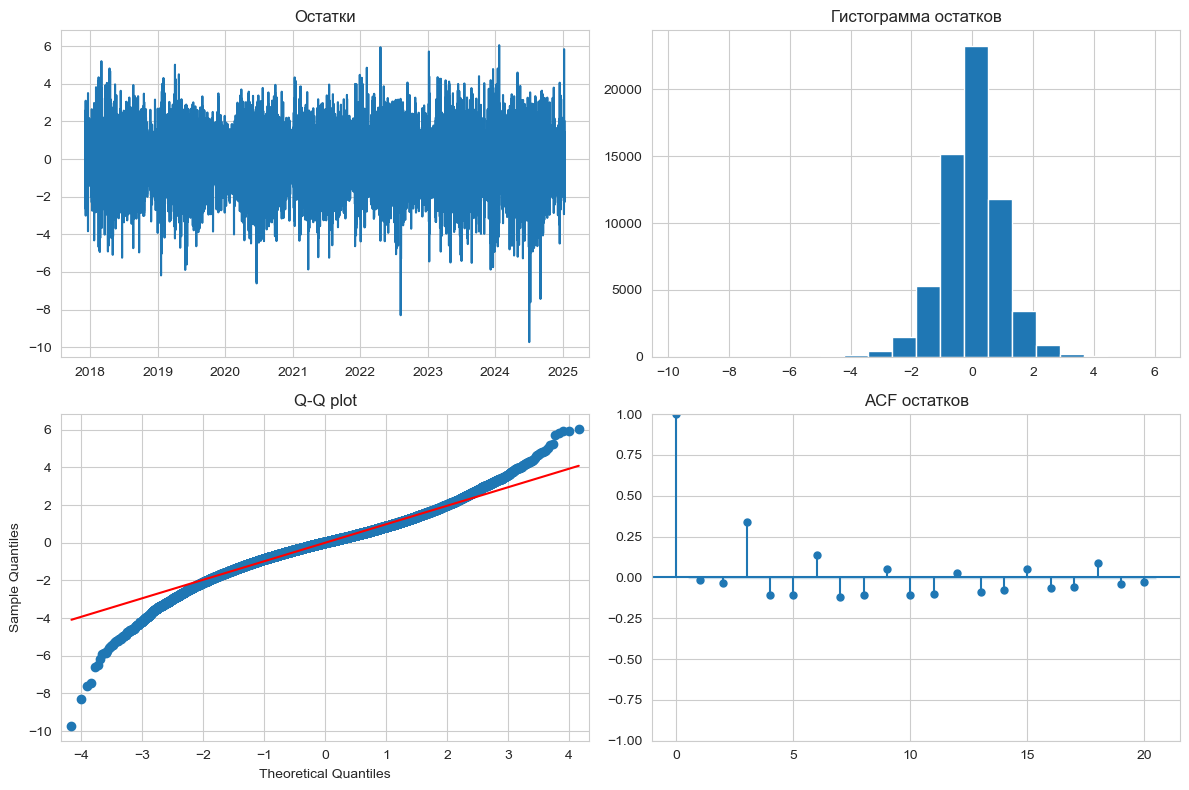

In [58]:
import statsmodels.api as sm

residuals = fit.resid

# Построение диагностических графиков
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# График остатков
axes[0, 0].plot(residuals)
axes[0, 0].set_title('Остатки')

# Гистограмма остатков
axes[0, 1].hist(residuals, bins=20)
axes[0, 1].set_title('Гистограмма остатков')

sm.qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title('Q-Q plot')

# Автокорреляционная функция (ACF)
sm.graphics.tsa.plot_acf(residuals, lags=20, ax=axes[1, 1])
axes[1, 1].set_title('ACF остатков')

plt.tight_layout()
plt.show()

Автокорреляционная функция и график остатков выглядят неплохо, однако гистограмма и график Квантиль-Квантиль показывают, что большинство ошибок модели вызваны внезапными отклонениями шума от нормы. То есть в наших данных слишком часто "вылезают" отклонения, которые модель не может описать.

## SARIMA

Во время изучения научных статей и литературы по этой модели я наткнулся на главу из авторитетного учебника по прогнозированию временных рядов: [Forecasting: Principles and Practice](https://otexts.com/fpp2/dhr.html)

В ней говорится о том, что модели семейств **ETS** и **ARIMA** первоочередно предназначены для прогнозирования временных рядов с малой сезонностью. Этим объясняются неадекватные 6 часов обучения предыдущей модели. **ARIMA** и вовсе имеет искусственный предел сезонности в 350 и физический в 200, что делает **SARIMA** с предыдущими предпосылками невозможной в реализации. 

Однако, здравый смысл подсказывает, что в данных помимо годичной сезонности также имеется дневная, которую также можно взять за основу модели. Учитывая, что прогноз должен быть создан всего на 3 дня, годовые изменения будут не так сильно ощутимы в данный период прогнозирования. Эти новые предпосылки предлагаю взять за основу **SARIMA** модели.

**SARIMA** (Seasonal, Auto Regression, Integrated, Moving Average) модель пытается объяснить значение ряда как линейную комбинацию предыдущих значений, ошибок, а также значений за предыдущие сезоны и их ошибок. Модель требует стационарности ряда, достигающейся путем дифференцирования. Все эти параметры настраиваются вручную. Начнем с простого - найдем порядок дифференцирования. Для этого используем упомянутый тест Дики-Фуллера и более строгий KPSS-тест. p_value в первом случае должен быть менее 0.05, а во втором - более. Не забудем про тренд в параметрах теста, так как в этой модели тренд не перетянет на себя одеяло и будет только содействовать прогнозирования.

In [59]:
from statsmodels.tsa.stattools import kpss

# Проведение ADF теста
adf_result = adfuller(df.temp)
print('Результаты ADF теста:')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'Критические значения: {adf_result[4]}')
print()

# Проведение KPSS теста
kpss_result = kpss(df.temp, regression='ct')  # 'c' для константы, 'ct' для константы и тренда
print('Результаты KPSS теста:')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')
print(f'Критические значения: {kpss_result[3]}')

Результаты ADF теста:
ADF Statistic: -6.529338666231796
p-value: 9.960333658871587e-09
Критические значения: {'1%': -3.4304548327072144, '5%': -2.861586334106275, '10%': -2.5667946620770707}

Результаты KPSS теста:
KPSS Statistic: 0.23362301458189658
p-value: 0.01
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


look-up table. The actual p-value is smaller than the p-value returned.



Как видим в первом случае p-значение и вправду оказалось менее 0.05, но тест KPSS наш ряд не прошел. Такой случай называется *разностно-стационарным* и он потребует дифференцирования. Выполним его.

In [39]:
# Вычисление первой разности
df_diff = df.temp.diff().dropna()  # diff() вычисляет разность, dropna() удаляет NaN

# Проведение ADF теста на первой разности
adf_result_diff = adfuller(df_diff)
print('Результаты ADF теста на первой разности:')
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print(f'Критические значения: {adf_result_diff[4]}')
print()

# Проведение KPSS теста на первой разности
kpss_result_diff = kpss(df_diff, regression='ct')  # 'c' для константы, 'ct' для константы и тренда
print('Результаты KPSS теста на первой разности:')
print(f'KPSS Statistic: {kpss_result_diff[0]}')
print(f'p-value: {kpss_result_diff[1]}')
print(f'Критические значения: {kpss_result_diff[3]}')

Результаты ADF теста на первой разности:
ADF Statistic: -39.759739827312416
p-value: 0.0
Критические значения: {'1%': -3.4304548343878336, '5%': -2.861586334849064, '10%': -2.5667946624724345}

Результаты KPSS теста на первой разности:
KPSS Statistic: 0.01934757173125765
p-value: 0.1
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


look-up table. The actual p-value is greater than the p-value returned.



Теперь оба тесты пройдены и мы можем смело принимать параметр i за единицу. Построим графики автокорреляции для оценки p и q.

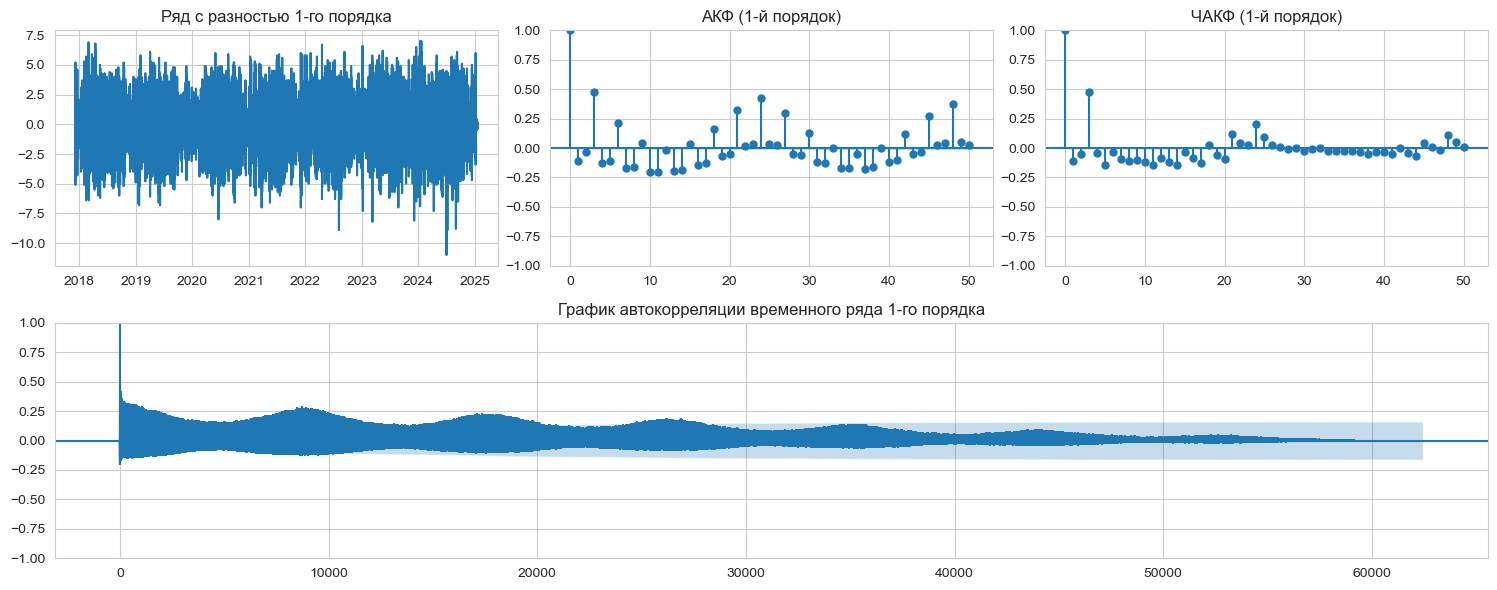

In [72]:
periods = 1
series = df.temp
lags = 50

if periods:
    series = series.diff(periods=periods).dropna()
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0, 0].plot(series)
axs[0, 0].set_title(f"Ряд с разностью {periods}-го порядка")
plot_acf(series, ax=axs[0, 1], lags=lags)
axs[0, 1].set_title(f"АКФ ({periods}-й порядок)")
plot_pacf(series, ax=axs[0, 2], lags=lags)
axs[0, 2].set_title(f"ЧАКФ ({periods}-й порядок)")

for ax in axs[1, :]:
    ax.remove()

axs[1, 0] = fig.add_subplot(212)

plot_acf(series, ax=axs[1, 0], lags=arange(len(series)), marker='')
axs[1, 0].set_title(f"График автокорреляции временного ряда {periods}-го порядка")

plt.tight_layout()
plt.show()

Графики АКФ и ЧАКФ резко обрываются на 1-м лаге, что говорит о равенстве этих параметров единице. Однако, с графиком АКФ происходит что-то непонятное. Каждое 3-е значение ведет себя примерно так как и должно (ночью холоднее, днем теплее), но значения между ними ведут себя искуственно, ненатурально. Есть подозрения, что поставщик данных не очень добросовестно выполнял свои задачи. Учитывая это и оглядываясь на другие работы, предлагаю взять параметр p за 1, а q за значения 1-3 и посмотреть на ошибки таких прогнозов.

Для определения сезонных параметров проделаем те же действия, но для сезонного порядка.

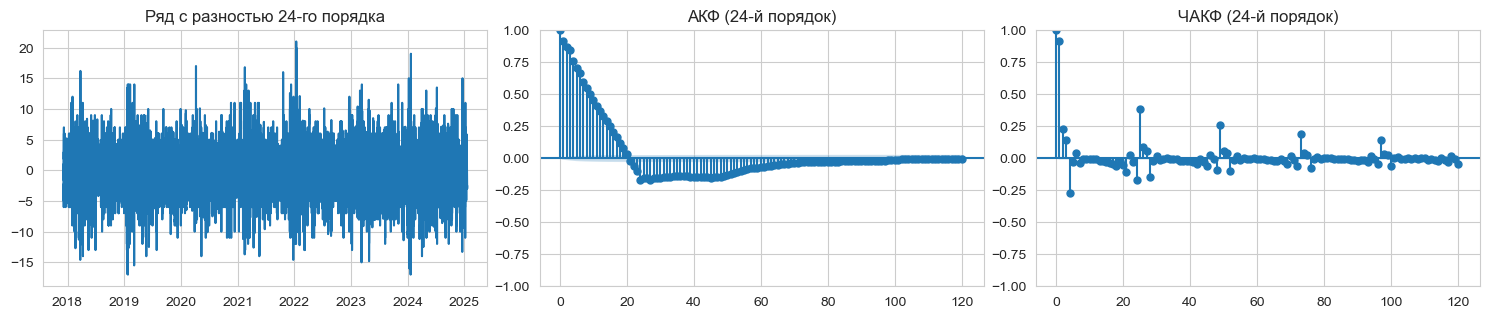

In [76]:
periods = 24
series = df.temp
lags = 120

if periods:
    series = series.diff(periods=periods).dropna()
fig, axs = plt.subplots(2, 3, figsize=(15, 6))

axs[0, 0].plot(series)
axs[0, 0].set_title(f"Ряд с разностью {periods}-го порядка")
plot_acf(series, ax=axs[0, 1], lags=lags)
axs[0, 1].set_title(f"АКФ ({periods}-й порядок)")
plot_pacf(series, ax=axs[0, 2], lags=lags)
axs[0, 2].set_title(f"ЧАКФ ({periods}-й порядок)")

for ax in axs[1, :]:
    ax.remove()

plt.tight_layout()
plt.show()

Ряд выглядит стационарным, проверим это предыдущими тестами.

In [78]:
# Вычисление первой разности
df_diff = df.temp.diff(periods=24).dropna()  # diff() вычисляет разность, dropna() удаляет NaN

# Проведение ADF теста на первой разности
adf_result_diff = adfuller(df_diff)
print('Результаты ADF теста на первой разности:')
print(f'ADF Statistic: {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')
print(f'Критические значения: {adf_result_diff[4]}')
print()

# Проведение KPSS теста на первой разности
kpss_result_diff = kpss(df_diff, regression='ct')  # 'c' для константы, 'ct' для константы и тренда
print('Результаты KPSS теста на первой разности:')
print(f'KPSS Statistic: {kpss_result_diff[0]}')
print(f'p-value: {kpss_result_diff[1]}')
print(f'Критические значения: {kpss_result_diff[3]}')

Результаты ADF теста на первой разности:
ADF Statistic: -33.43276830413233
p-value: 0.0
Критические значения: {'1%': -3.4304548730569517, '5%': -2.861586351939793, '10%': -2.5667946715693035}

Результаты KPSS теста на первой разности:
KPSS Statistic: 0.008626355370847391
p-value: 0.1
Критические значения: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


look-up table. The actual p-value is greater than the p-value returned.



И вправду, все отлично, значит D = 1. Также в ЧАКФ заметны пики на 24 лагах, что значит сезонная компонента авторегрессии значима и будет довольно высокой (более 1). Что не скажешь об АКФ, где тренд затухает вплоть до 24 лага. Это говорит о том, что значение Q примем за 1.

В результате можем построить модели и провалидировать их, чтобы найти лучшие.

In [81]:
from pmdarima import auto_arima

# Автоматический подбор параметров SARIMA
model = auto_arima(
    df.temp,  # Ваш временной ряд
    seasonal=True,  # Учитывать сезонность
    m=24,  # Сезонный период
    d=1,  # Автоматически определить d
    D=1,  # Автоматически определить D
    start_p=1, start_q=1,  # Начальные значения p и q
    max_p=1, max_q=3,  # Максимальные значения p и q
    start_P=1, start_Q=0,  # Начальные значения P и Q
    max_P=3, max_Q=1,  # Максимальные значения P и Q
    trace=True,  # Вывод процесса подбора
    error_action='ignore',  # Игнорировать ошибки
    suppress_warnings=True,  # Игнорировать предупреждения
    stepwise=True  # Пошаговый подбор
)

print(model.summary())

Performing stepwise search to minimize aic


MemoryError: Unable to allocate 1.16 GiB for an array with shape (50, 50, 62443) and data type float64

По всей видимости перебор для нас - непозволительная роскошь, в таком случае построим единственную модель на основе предшествующего анализа.

In [135]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

order = (1, 1, 1)  # Несезонные параметры
seasonal_order = (2, 1, 1, 24)  # Сезонные параметры

# Построение модели
model = SARIMAX(df.temp, order=order, seasonal_order=seasonal_order)
results = model.fit()

# Вывод результатов
print(results.summary())

MemoryError: Unable to allocate 2.55 GiB for an array with shape (74, 74, 62443) and data type float64

Видимо мой компьютер не способен обработать такой массив данных. Также замечу, что прогнозирование требуется не разовое, а ежедневное и постоянное, на все 800+ вышек. Из всего выше описанного заключаю, что модель не подходит для поставленной задачи.